In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [46]:
saved_info = {}

In [5]:
# Reading datasets
dfs = []
for i in range(1,5):
    path = 'datasets/UNSW-NB15/UNSW-NB15_{}.csv'  # There are 4 input csv files
    dfs.append(pd.read_csv(path.format(i), header = None))
all_data = pd.concat(dfs).reset_index(drop=True)  # Concat all to a single df

In [13]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [48]:
df_col = pd.read_csv('datasets/UNSW-NB15/NUSW-NB15_features.csv', encoding='ISO-8859-1')

In [49]:
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

In [9]:
all_data.columns=df_col['Name']

In [12]:
all_data.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


In [50]:
saved_info["columns"]=df_col['Name'][df_col['Name']!='attack_cat'].tolist()

In [20]:
del df_col

In [21]:
train,test=train_test_split(all_data,test_size=0.3,random_state=1)

In [22]:
del all_data

In [23]:
print(train.shape,'\n',test.shape)

(1778032, 49) 
 (762015, 49)


In [25]:
train.isnull().sum()

Name
srcip                     0
sport                     0
dstip                     0
dsport                    0
proto                     0
state                     0
dur                       0
sbytes                    0
dbytes                    0
sttl                      0
dttl                      0
sloss                     0
dloss                     0
service                   0
sload                     0
dload                     0
spkts                     0
dpkts                     0
swin                      0
dwin                      0
stcpb                     0
dtcpb                     0
smeansz                   0
dmeansz                   0
trans_depth               0
res_bdy_len               0
sjit                      0
djit                      0
stime                     0
ltime                     0
sintpkt                   0
dintpkt                   0
tcprtt                    0
synack                    0
ackdat                    0
is_sm_ips_ports

In [26]:
train['attack_cat'] = train.attack_cat.fillna(value='normal').apply(lambda x: x.strip().lower())

In [27]:
train['ct_flw_http_mthd'] = train.ct_flw_http_mthd.fillna(value=0)

In [28]:
train['is_ftp_login'] = (train.is_ftp_login.fillna(value=0)).astype(int)

In [30]:
train['attack_cat'].value_counts()

attack_cat
normal            1553058
generic            151011
exploits            31182
fuzzers             16876
dos                 11419
reconnaissance       9779
analysis             1857
backdoor             1284
shellcode            1054
backdoors             387
worms                 125
Name: count, dtype: int64

In [32]:
train['attack_cat'].value_counts()/len(train)*100

attack_cat
normal            87.347022
generic            8.493154
exploits           1.753737
fuzzers            0.949139
dos                0.642227
reconnaissance     0.549990
analysis           0.104441
backdoor           0.072215
shellcode          0.059279
backdoors          0.021766
worms              0.007030
Name: count, dtype: float64

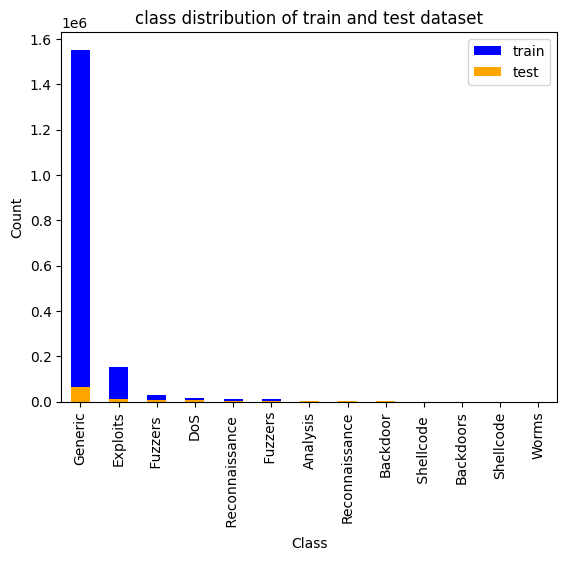

In [34]:
plt.figure()
plt.title("class distribution of train and test dataset")
train['attack_cat'].value_counts().plot(kind="bar", color='b', label="train")
test['attack_cat'].value_counts().plot(kind="bar", color='orange', label="test")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [35]:
train.dtypes.value_counts()

int64      29
float64    11
object      9
Name: count, dtype: int64

In [38]:
train.select_dtypes(include='object').columns.tolist()

['srcip',
 'sport',
 'dstip',
 'dsport',
 'proto',
 'state',
 'service',
 'ct_ftp_cmd',
 'attack_cat']

In [41]:
train.select_dtypes(include=np.number).columns.tolist()

['dur',
 'sbytes',
 'dbytes',
 'sttl',
 'dttl',
 'sloss',
 'dloss',
 'sload',
 'dload',
 'spkts',
 'dpkts',
 'swin',
 'dwin',
 'stcpb',
 'dtcpb',
 'smeansz',
 'dmeansz',
 'trans_depth',
 'res_bdy_len',
 'sjit',
 'djit',
 'stime',
 'ltime',
 'sintpkt',
 'dintpkt',
 'tcprtt',
 'synack',
 'ackdat',
 'is_sm_ips_ports',
 'ct_state_ttl',
 'ct_flw_http_mthd',
 'is_ftp_login',
 'ct_ftp_cmd',
 'ct_srv_src',
 'ct_srv_dst',
 'ct_dst_ltm',
 'ct_src_ltm',
 'ct_src_dport_ltm',
 'ct_dst_sport_ltm',
 'ct_dst_src_ltm',
 'label']

In [39]:
train['ct_ftp_cmd'] = train['ct_ftp_cmd'].replace(to_replace=' ', value=0).astype(int)

In [52]:
saved_info['binary_col'] = ['is_sm_ips_ports', 'is_ftp_login']

In [42]:
train['is_ftp_login'] = np.where(train['is_ftp_login']>1, 1, train['is_ftp_login'])

In [44]:
train['service'] = train['service'].apply(lambda x:"none" if x=="-" else x)

In [45]:
train['attack_cat'] = train['attack_cat'].replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())

In [53]:
path="/home/dezs/projects/myIDS/datasets/myDataset/"
train.to_csv(path+'train_alldata_EDA.csv', index=False)
test.to_csv(path+'test_alldata_EDA.csv', index=False)
pickle.dump(saved_info, open(path+'saved_infos', 'wb'))